In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
features = pd.read_csv("temps.csv")
features.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


* year,moth,day,week分别表示的具体的时间
* temp_2：前天的最高温度值
* temp_1：昨天的最高温度值
* average：在历史中，每年这一天的平均最高温度值
* actual：这就是我们的标签值了，当天的真实最高温度
* friend：猜测的可能值

In [4]:
import datetime

# 处理时间数据
years = features['year']
months = features['month']
days = features['day']

# datetime格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

In [5]:
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

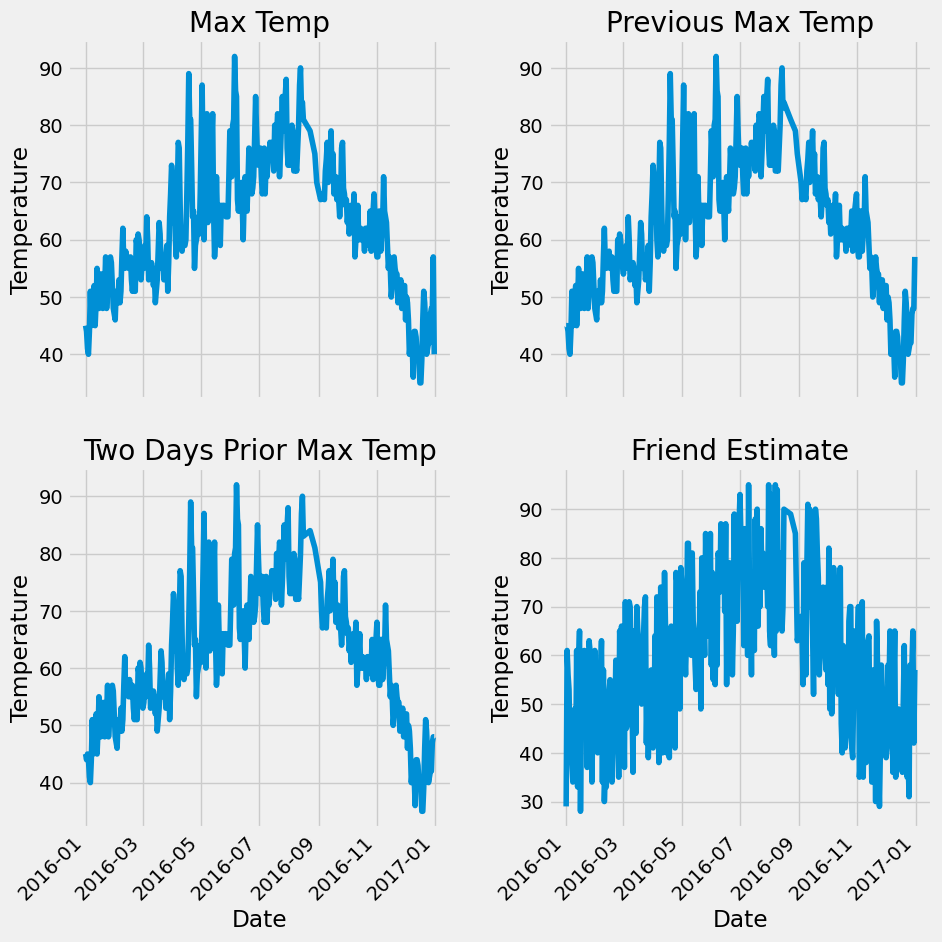

In [6]:
# 指定默认风格
plt.style.use('fivethirtyeight')

# 设置布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.autofmt_xdate(rotation=45)

# 标签值
ax1.plot(dates, features['actual'])
ax1.set_xlabel('');
ax1.set_ylabel('Temperature');
ax1.set_title('Max Temp')

# 昨天
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel('');
ax2.set_ylabel('Temperature');
ax2.set_title('Previous Max Temp')

# 前天
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date');
ax3.set_ylabel('Temperature');
ax3.set_title('Two Days Prior Max Temp')

# 逼朋友
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date');
ax4.set_ylabel('Temperature');
ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

In [7]:
# 独热编码
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,True,False,False,False,False,False,False
1,2016,1,2,44,45,45.7,44,61,False,False,True,False,False,False,False
2,2016,1,3,45,44,45.8,41,56,False,False,False,True,False,False,False
3,2016,1,4,44,41,45.9,40,53,False,True,False,False,False,False,False
4,2016,1,5,41,40,46.0,44,41,False,False,False,False,False,True,False


In [8]:
features.shape

(348, 15)

In [9]:
# 标签
labels = np.array(features['actual'])

# 在特征中去掉标签 (即按照列去去除)
features = features.drop('actual', axis=1)

# 名字单独保存一下，以备后患
feature_list = list(features.columns)

# 转换成合适的格式
features = np.array(features)

In [10]:
features

array([[2016, 1, 1, ..., False, False, False],
       [2016, 1, 2, ..., False, False, False],
       [2016, 1, 3, ..., False, False, False],
       ...,
       [2016, 12, 29, ..., True, False, False],
       [2016, 12, 30, ..., False, False, False],
       [2016, 12, 31, ..., False, False, False]], dtype=object)

In [11]:
# z-score标准化（规范化）
# 新数据=（原数据- 均值）/ 标准差
from sklearn import preprocessing

input_features = preprocessing.StandardScaler().fit_transform(features)

In [12]:
print(input_features.shape)
input_features

(348, 14)


array([[ 0.        , -1.5678393 , -1.65682171, ..., -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        , -1.5678393 , -1.54267126, ..., -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        , -1.5678393 , -1.4285208 , ..., -0.40482045,
        -0.41913682, -0.40482045],
       ...,
       [ 0.        ,  1.5810006 ,  1.53939107, ...,  2.47023092,
        -0.41913682, -0.40482045],
       [ 0.        ,  1.5810006 ,  1.65354153, ..., -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        ,  1.5810006 ,  1.76769198, ..., -0.40482045,
        -0.41913682, -0.40482045]])

In [13]:
# 数据转为Tensor格式
x = torch.tensor(input_features, dtype=float)
y = torch.tensor(labels, dtype=float)

'''
每个样本14个特征，通过网络最终每个样本得到一个预测温度值
14 —— 14*128 —— 128*1 —— 1
'''
# 权重（偏置）参数随机初始化
weights = torch.randn((14, 128), dtype=float, requires_grad=True)
biases = torch.randn(128, dtype=float, requires_grad=True)
weights2 = torch.randn((128, 1), dtype=float, requires_grad=True)
biases2 = torch.randn(1, dtype=float, requires_grad=True)

learning_rate = 0.001
losses = []

# 迭代更新1000次
for i in range(1000):
    # 计算隐层
    hidden = x.mm(weights) + biases  # 做矩阵乘法 wx + b
    # 加入ReLU激活函数
    hidden = torch.relu(hidden)
    # 预测结果（第二层）
    predictions = hidden.mm(weights2) + biases2
    # 通计算损失
    loss = torch.mean((predictions - y) ** 2)  # 均方误差
    losses.append(loss.data.numpy())

    # 打印损失值--每迭代100次打印一次当前损失
    if i % 100 == 0:
        print('loss:', loss)
    #返向传播计算
    loss.backward()

    #更新参数
    weights.data.add_(- learning_rate * weights.grad.data)
    biases.data.add_(- learning_rate * biases.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)
    biases2.data.add_(- learning_rate * biases2.grad.data)

    # 每次迭代都得记得清空
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()
    biases2.grad.data.zero_()

loss: tensor(2312.7856, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(159.7467, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(150.2063, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(146.4777, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(144.4577, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(143.2285, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(142.3964, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.7961, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.3483, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.0028, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [14]:
predictions.shape

torch.Size([348, 1])

## 调包简化网络模型

In [15]:
input_size = input_features.shape[1]  # 输入的特征个数
hidden_size = 128
output_size = 1
batch_size = 16  # 按批处理，计算各批损失
my_nn = torch.nn.Sequential(  # 序列模块
    torch.nn.Linear(input_size, hidden_size),  # 第一层全连接wx + b，权重参数自动初始化
    torch.nn.Sigmoid(),  # 128个特征送入sigmoid
    torch.nn.Linear(128, 256),  # 第一层全连接wx + b，权重参数自动初始化
    torch.nn.Sigmoid(),  # 128个特征送入sigmoid
    torch.nn.Linear(256, output_size),  # 输出，全连接wx + b
)
cost = torch.nn.MSELoss(reduction='mean')  # 均方误差
optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001)  # 优化器

In [16]:
# 训练网络
losses = []
for i in range(1000):
    batch_loss = []
    # MINI-Batch方法来进行训练
    for start in range(0, len(input_features), batch_size):
        end = start + batch_size if start + batch_size < len(input_features) else len(input_features)  # 划定batch的范围
        xx = torch.tensor(input_features[start:end], dtype=torch.float, requires_grad=True)  # 取得一个batch的数据
        yy = torch.tensor(labels[start:end], dtype=torch.float, requires_grad=True)  # 取得一个batch的真实标签值
        prediction = my_nn(xx)  # 传入网络
        loss = cost(prediction, yy)
        optimizer.zero_grad()  # 梯度清零
        loss.backward(retain_graph=True)  # 反向传播
        optimizer.step()  # 更新
        batch_loss.append(loss.data.numpy())  # 损失预存

    # 打印损失
    if i % 100 == 0:
        losses.append(np.mean(batch_loss))  # 每一个batch的平均损失值都加进去
        print(i, np.mean(batch_loss))

0 3676.1697
100 37.00215
200 35.55824
300 34.574707
400 33.808258
500 33.145466
600 32.637028
700 32.27021
800 31.970274
900 31.702925


In [17]:
# 预测结果
x = torch.tensor(input_features, dtype=torch.float)
predict = my_nn(x).data.numpy()

In [18]:
# 转换日期格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data={'date': dates, 'actual': labels})

# 同理，再创建一个来存日期和其对应的模型预测值
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in
              zip(years, months, days)]

test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

predictions_data = pd.DataFrame(data={'date': test_dates, 'prediction': predict.reshape(-1)})

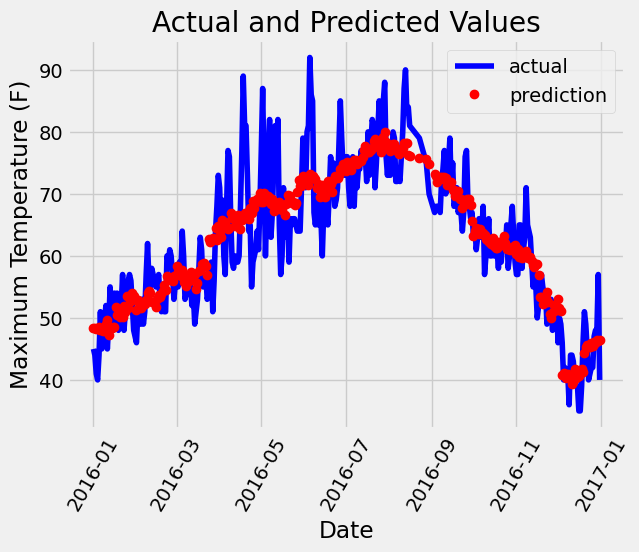

In [19]:
# 真实值
plt.plot(true_data['date'], true_data['actual'], 'b-', label='actual')

# 预测值
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label='prediction')
plt.xticks(rotation=60);
plt.legend()

# 图名
plt.xlabel('Date');
plt.ylabel('Maximum Temperature (F)');
plt.title('Actual and Predicted Values');

# 下图为增加一层256个神经元的网络
# 在网络中添加层数会越来越过拟合